# Modeling the Temperature Control Laboratory: Part 2

## Interacting Heaters

Our next model considers the interaction between the two heaters. From the step response it is obvious that the heaters interact, and we need to understand how that affects the dynamic performance.  Will we see qualitative differences in the step response once we've included the second heater?

\begin{align}
C_p\frac{dT_1}{dt} & = U_a(T_{amb} - T_1) + U_b(T_2 - T_1) + P_1u_1\\
C_p\frac{dT_2}{dt} & = U_a(T_{amb} - T_2) + U_b(T_1 - T_2) + P_2u_2
\end{align}

As a first step we isolate the bare derivatives on the left-hand side of the equations. This is good practice in situations where you expect to be doing numerical simulation.

\begin{align}
\frac{dT_1}{dt} & = \frac{U_a}{C_p}(T_{amb} - T_1) + \frac{U_b}{C_p}(T_2 - T_1) + \frac{P_1}{C_p}u_1\\
\frac{dT_2}{dt} & = \frac{U_a}{C_p}(T_{amb} - T_2) + \frac{U_b}{C_p}(T_1 - T_2) + \frac{P_2}{C_p}u_2
\end{align}

## Deviation Variables

As before, the equations appear somewhat simpler if we introduce deviation variables from a nominal state. In this case we'll use the ambient temperature as the reference, so the deviation variable will express deviation from ambient.

\begin{align}
T_1' & = T_1 - T_{amb} \\
T_2' & = T_2 - T_{amb}
\end{align}

Then gathering terms

\begin{align}
\frac{dT_1'}{dt} & = -\frac{U_a+U_b}{C_p}T_1' + \frac{U_b}{C_p}T_2' + \frac{P_1}{C_p}u_1\\
\frac{dT_2'}{dt} & = -\frac{U_a+U_b}{C_p}T_2' + \frac{U_b}{C_p}T_1' + \frac{P_2}{C_p}u_2
\end{align}

An alternative way to express these equations is in matrix/vector form.  We won't use this today, but later will make extensive use of this 'state-space' model of a linear system.

\begin{align}
\left[\begin{array}{c}\frac{dT_1'}{dt} \\ \frac{dT_2'}{dt}\end{array}\right] & = 
\left[\begin{array}{cc}-\frac{U_a+U_b}{C_p} & \frac{U_b}{C_p} \\ \frac{U_b}{C_p} & -\frac{U_a+U_b}{C_p} \end{array}\right]
\left[\begin{array}{c}T_1' \\ T_2'\end{array}\right] +
\left[\begin{array}{cc}\frac{P_1}{C_p} & 0 \\ 0 & \frac{P_2}{C_p} \end{array}\right]
\left[\begin{array}{c}u_1 \\ u_2\end{array}\right]
\end{align}

## Steady State

The steady state is found by setting the derivatives to zero. We'll use a bar over the dependent variables to designate steady state values.

\begin{align}
0 & = -(U_a+U_b)\bar{T}_{1}' + U_b\bar{T}_{2}' + P_1\bar{u}_{1}\\
0 & = -(U_a+U_b)\bar{T}_{2}' + U_b\bar{T}_{1}' + P_2\bar{u}_{1}
\end{align}

Our challenge is to solve the following 2x2 system of linear equations for the steady state temperatures.

\begin{align} 
\left[\begin{array}{cc}(U_a+U_b) & -U_b \\ -U_b & (U_a+U_b) \end{array}\right]
\left[\begin{array}{c}\bar{T}_1' \\ \bar{T}_2'\end{array}\right] & = 
\left[\begin{array}{c} P_1\bar{u}_1 \\ P_2\bar{u}_2\end{array}\right]
\end{align}

The solution to these equations is a bit of work, but you should be able to verify

\begin{align}
\bar{T}_1' & = \frac{(U_a+U_b)}{U_a(U_a+2U_b)}P_1\bar{u}_1 + \frac{U_b}{U_a(U_a+2U_b)}P_2\bar{u}_2 \\
\bar{T}_2' & = \frac{U_b}{U_a(U_a+2U_b)}P_1\bar{u}_1 + \frac{(U_a+U_b)}{U_a(U_a+2U_b)}P_2\bar{u}_2
\end{align}


## Estimating $U_a$ and $U_b$

Experimental step response data gives us the information needed to estimate parameters $U_a$ and $U_b$. Rearranging the steady state equations, we find a pair of linear equations for $U_a$ and $U_b$.

\begin{align}
\bar{T}_{1}'U_a  + (\bar{T}_{1}'-\bar{T}_{2}')U_b & = P_1\bar{u}_{1}\\
\bar{T}_{2}'U_a + (\bar{T}_{2}'-\bar{T}_{1}')U_b & = P_2\bar{u}_{1}
\end{align}

There is an analytical solution to these equations

\begin{align}
U_a & = \frac{P_1\bar{u}_1 + P_2\bar{u}_2}{\bar{T}_1' + \bar{T}_2'}\\
U_b & = \frac{\bar{T}_2'P_1\bar{u}_1 - \bar{T}_1'P_2\bar{u}_2}{(\bar{T}_1' - \bar{T}_2')(\bar{T}_1' + \bar{T}_2')}
\end{align}

The step response data gives us information about steady-state that can be used to estimate values for $U_a$ and $U_b$. First we plot the step response data (see Part 1 if this cell cannot find the data set.)

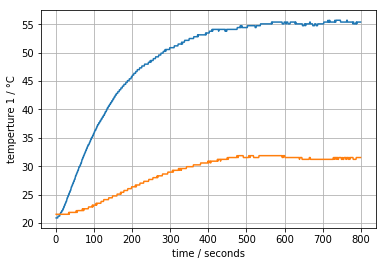

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Step_Test_Data.csv').set_index('Time')[1:]
t = data.index
T1 = data['T1'].values
T2 = data['T2'].values

plt.plot(t, T1, t, T2)
plt.xlabel('time / seconds')
plt.ylabel('temperture 1 / °C')
plt.grid()

**Exercise:** Roughly speaking, the has an increase of 35 degrees and T2 and increase of 10 degrees due to a setting u1 to 50% of the maximum power of 4 watts.  Use that information and the above equations to estimate values for $U_a$ and $U_b$.

## Simulation with odeint

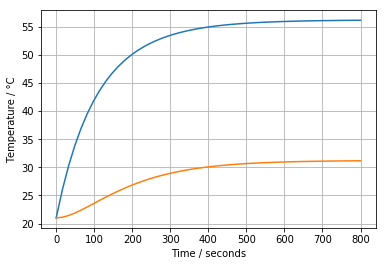

In [2]:
%matplotlib inline
import numpy as np                  # basic package for numerical calculations
import matplotlib.pyplot as plt     # plotting package
from scipy.integrate import odeint

# parameter values and units
P1 = 4                 # watts
P2 = 2                 # watts
Ua = 0.044             # watts/deg C
Ub = 0.018             # watts/deg C
Cp = 6                 # joules/deg C
u1 = 0.5               # steady state value of u1 (fraction of total power)
u2 = 0.0               # steady state value of u2 (fraction of total power)
T_ambient = 21         # ambient temperature of the surroundings

def deriv(T,t):
    T1, T2 = T
    dT1 = -(Ua + Ub)*T1/Cp + Ub*T2/Cp + P1*u1/Cp
    dT2 = Ub*T1/Cp - (Ua + Ub)*T2/Cp + P2*u2/Cp
    return [dT1, dT2]

# compute the transient solution
t = np.linspace(0,800)
T = odeint(deriv, [0,0], t)

# plot
plt.plot(t, T + T_ambient)
plt.xlabel('Time / seconds')
plt.ylabel('Temperature / °C')
plt.grid()

## Fitting the Model to Measured Step Response Data

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from ipywidgets import interact

data = pd.read_csv('Step_Test_Data.csv').set_index('Time')[1:]
t = data.index
T1 = data['T1'].values
T2 = data['T2'].values

# known parameter values
P1 = 4
u1 = 0.5   # steady state value of u1 (fraction of total power)
P2 = 2
u2 = 0.0
T_ambient = 21

def compare(Ua, Ub, Cp):

    def deriv(T,t):
        T1, T2 = T
        dT1 = -(Ua + Ub)*T1/Cp + Ub*T2/Cp + P1*u1/Cp
        dT2 = Ub*T1/Cp - (Ua + Ub)*T2/Cp + P2*u2/Cp
        return [dT1, dT2]

    T = odeint(deriv, [0,0], t)

    # plot
    plt.plot(t, T + T_ambient, t, T1, t, T2)
    plt.xlabel('Time / seconds')
    plt.ylabel('Temperature / °C')
    plt.grid()
    plt.text(400,28,'Ua = ' + str(Ua))
    plt.text(400,24,'Ub = ' + str(Ub))
    plt.text(400,20,'Cp = ' + str(Cp))

# parameter values and units
P1 = 4                 # watts
P2 = 2                 # watts
Ua = 0.044             # watts/deg C
Ub = 0.018             # watts/deg C
Cp = 7                 # joules/deg C

interact(compare, Ua=(0,0.06,0.001), Ub=(0,0.06,0.001), Cp=(2,10,0.002))

A Jupyter Widget

<function __main__.compare>